**Executed:** Mon Oct 10 19:02:21 2016

**Duration:** 153 seconds.

In [1]:
%reset -f 
dataframefile = "../sample_data/dataframes_sample.pkl"
samplename = "twomg"
highbinding_glycans = {75,
  163,
  185,
  336,
  337,
  372,
  543,
  545,
  547,
  549,
  550,
  551,
  552,
  565,
  566,
  569,
  572,
  576,
  577,
  578,
  579,
  580,
  581,
  582,
  583,
  584,
  585,
  586,
  587,
  588,
  589}
highbinding_glycans = {543,
 547,
 549,
 550,
 551,
 565,
 566,
 569,
 577,
 578,
 579,
 580,
 581,
 582,
 588,
 589}

In [2]:
# Cell inserted during automated execution.
samplename = 'fivemg_filter50'
dataframefile = '../results/galectin-3/dataframes_galectin.pkl'
highbinding_glycans = set([577, 578, 579, 580, 581, 582, 551, 585, 586, 587, 588, 589, 547, 565, 566, 550, 569, 543, 549])

### Notebook arguments

- **dataframefile** (*string*): which pickled data file to load

- **samplename** (*string*): name of particular experiment

- **highbinding_glycans** (*list or set *): list of integers which refer to the id of glycans as found in the dataframe file

# MCAW analysis


Pass in glycan ids and will look up the glycan IUPAC from a dataframe, and then get the KCF's and pass these to the RINGS MCAW tool. 

You can either run this notebook directly, or run it through the [meta notebook](meta_run_mcaw_analysis.ipynb) for batch processing.


In [3]:
## import all required dependencies

In [4]:
# standard imports
import urllib
import urllib2
import os
import sys
import json
import StringIO
import pickle

# dataframe and numerical
import pandas as pd
import numpy as np

# plotting
import matplotlib.pyplot as plt
%matplotlib inline
# plotting params
from matplotlib import rcParams
rcParams["figure.figsize"] = 10, 8

#scipy
from scipy import stats
from scipy.special import erf
from scipy import sqrt

# glypy
import glypy
from glypy.plot import plot
from glypy.io import glycoct

# other modules
sys.path.append('../scripts/')
import post_glycan_convert as pgc
import post_kcf_to_image as pki
import post_mcaw as pm

# iPython
from IPython.display import Image,display, HTML

In [5]:
# load dataframe
subdir="./"

if not os.path.isfile(dataframefile):
    exit(1)
with open(os.path.join(subdir, dataframefile)) as f:
    dataframes = pickle.load(f)
    
    
dataframes[0]["sample"]
frame=dataframes[0]["dataframe"]
frame.head()

,Chart Number,Structure on Masterlist,Average RFU,StDev,% CV
0,1,Gala-Sp8,32.573825,10.853264,33.318974
1,2,Glca-Sp8,32.550600,20.740342,63.717235
2,3,Mana-Sp8,43.420175,5.334342,12.285399
3,4,GalNAca-Sp8,18.625950,5.312952,28.524464
4,5,GalNAca-Sp15,36.695600,13.101250,35.702508


In [6]:
# create a data frame with the glycan and the spacer as separate columns

Structure="Structure on Masterlist"

df=pd.concat([frame["Chart Number"], frame[Structure]], axis=1)
              
df.head()
#frame["Structure"]
df[Structure].str.extract('(.*-)')
df["Glycan"]=df[Structure].str.extract('(.*-)').str.strip('-')

#df['Structure'].str.extract('(-Sp.+?$)')
df["Spacer"]=df[Structure].str.split('.*-').str[1]
df

/home/cbarnett/anaconda2/envs/pynotes/lib/python2.7/site-packages/ipykernel/__main__.py:9: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)
/home/cbarnett/anaconda2/envs/pynotes/lib/python2.7/site-packages/ipykernel/__main__.py:10: FutureWarning: currently extract(expand=None) means expand=False (return Index/Series/DataFrame) but in a future version of pandas this will be changed to expand=True (return DataFrame)


,Chart Number,Structure on Masterlist,Glycan,Spacer
0,1,Gala-Sp8,Gala,Sp8
1,2,Glca-Sp8,Glca,Sp8
2,3,Mana-Sp8,Mana,Sp8
3,4,GalNAca-Sp8,GalNAca,Sp8
4,5,GalNAca-Sp15,GalNAca,Sp15
5,6,Fuca-Sp8,Fuca,Sp8
6,7,Fuca-Sp9,Fuca,Sp9
7,8,Rhaa-Sp8,Rhaa,Sp8
8,9,Neu5Aca-Sp8,Neu5Aca,Sp8
9,10,Neu5Aca-Sp11,Neu5Aca,Sp11


In [7]:
# create a function that plots using glypy

def plotter(func):
    """
    A decorator that plots the function .
    (it actually just prints it, but it could be logging!)
    """
    def wrapper(*args, **kwargs):
        res = func(*args, **kwargs)
        #print func.__name__, args, kwargs
        #plot(res,label=True)
        return res
    return wrapper

@plotter
def get_gly_iupac(iupacstring):
    try:
        kchandle = StringIO.StringIO(iupacstring)
        kcf=pgc.mechanise_glycan_convert(kchandle, "Kcf", "text")
        kchandle2 = StringIO.StringIO(kcf)
        gct=pgc.mechanise_glycan_convert(kchandle2, "Glycoct", "text")
        return glycoct.loads(gct)
    except:
        return iupacstring

In [8]:
# create a dataframe for the highbinders
highbinders_df = df[df["Chart Number"].isin(highbinding_glycans)]


post_glycan_convert.py:55: UserWarning: gzip transfer encoding is experimental!
  br.set_handle_gzip(True)


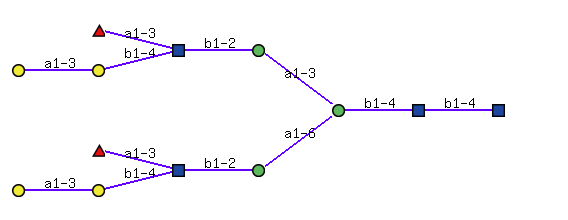

In [9]:
# Not always able to get iupac-> kcf-> glycoct
# why not just pull imaged from kcf-> image

def get_gly_image(iupacstring):
    try:
        kchandle = StringIO.StringIO(iupacstring)
        kcf=pgc.mechanise_glycan_convert(kchandle, "Kcf", "text")
        kchandle2 = StringIO.StringIO(kcf)
        gct=pki.post_rings_kcf_to_image(kchandle2)
        return pki.get_first_image_from_html(gct).encode("base64")
    except:
        return iupacstring

aimg= get_gly_image(df["Glycan"][372])

Image(aimg) 

In [10]:

highbinders_df["Image"]=highbinders_df["Glycan"]
# create a function called to http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html
# maps apply to the showl frame.... 
def map_image(x):
    # that, if x is a string,
    return '<html><img src="data:image/png;base64,'+urllib.quote(get_gly_image(x).rstrip('\n'))+'"/></html>'
    #return '<html><img src="data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAcIAAACWCAYAAABNcIgQAAAHM0lEQVR4nO3d32vXhR7H8ZdaSwoxCSLCYEOaw12YtIIIphe7S/+C8iIIIQI3+6GjIJ0gbWL12SC6MAhd3Xhp367sotKKKLd1EWOSFARRQiCMaivmztWR0+Gc06mjfj2+H4/r7fN5fQbjyeez7bMVy8vLywGAola2ewAAtJMQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhACUJoQAlCaEAJQmhBCG83NzWVubq7dM6A0IYQ2OHPmTPr6+nL//ffnvvvuS19fXz766KN2z4KShBCuoQsXLmTXrl3ZunVrzp49m+7u7vT09OTs2bPp7+/Prl27cuHChXbPhFKEEK6BX375JQcOHEhXV1eOHj2azs7OnDx5MlNTU5mens7JkyfT2dmZo0ePpqurKwcOHMjCwkK7Z0MJQghX0fLyco4fP57u7u6MjIzkpptuStM0mZ2dzY4dOy5/3I4dOzI7O5umabJq1aqMjIzk3nvvzfHjx7O8vNzGK4Ab34pl32VwVczMzGRoaCgffPBBVq5cmSeeeCL79+/P3Xff/R8/77vvvsvIyEjeeOONXLp0KVu3bs34+Hg2b958jZZDLUIIV9gPP/yQ5557Lm+//XYuXbqUhx9+OE3TpK+v708d5/PPP8/g4GA+/vjjrFy5Mo8++miOHDmSO++88yoth5o8GoUrZHFxMWNjY+np6cnk5GTWr1+fEydO5PTp0386gknS19eXM2fO5MSJE1m/fn0mJyezcePGjI2NZXFx8SpcAdTkjhCugFarlWeeeSbnzp3L6tWrs2/fvuzduze33nrrFTn+zz//nMOHD2dsbCwLCwvp7u7Oyy+/nO3bt1+R40NlQgj/gy+//DJDQ0N57733kiQ7d+7MoUOHcs8991yV83377bd54YUXMjk5mSQZGBhI0zTp7e29KueDCoQQ/oKLFy9m//79ef311/Pbb79l8+bNaZom27Ztuybnf//99zM0NJQvvvgiN998c5588skcPHgwa9euvSbnhxuJnxHCn7C0tJTx8fFs2LAhExMTWbduXY4dO5apqalrFsEk2bZtW6ampnLs2LGsW7cuExMT2bBhQ8bHx7O0tHTNdsCNwB0h/Jc+/PDDDA4OZmZmJh0dHdmzZ0+Gh4dz++23t3XXxYsXMzo6mldffTW//vprtmzZkqZp0t/f39Zd8P9CCOEPfP3119m9e3darVaS5JFHHskrr7yS7u7uNi/7vXPnzuXpp5/Ou+++myTZvn17JiYm0tXV1eZlcH3zaBT+jfn5+QwPD6e3tzetViu9vb05depUWq3WdRfBJOnu7k6r1cqpU6eyadOmy5uHh4czPz/f7nlw3RJC+Cd/fy1aT09PxsbG0tHRkaZpMj09nYGBgXbP+0MDAwOZmZlJ0zTp6Oi4/LeNXtcG/5pHo/APPvnkkwwODuazzz7LqlWr8tRTT+XFF1/MHXfc0e5pf8mPP/6YgwcP5rXXXsvS0lIeeOCBjI+P56GHHmr3NLhuCCEk+f7777N379689dZbWV5eTn9/f5qmyZYtW9o97YqYnp7O4OBgTp8+nRUrVuSxxx7L4cOHc9ddd7V7GrSdEFLawsJCRkdHc+TIkfz000/p7OzMxMTE7/4zxI3knXfeye7du/PNN9/ktttuy7PPPpvh4eGsXr263dOgbYSQsj799NM8/vjjmZ2dzS233JI9e/bk+eefz5o1a9o97aqan5/PoUOH0jRNFhcXs2nTprz55pt58MEH2z0N2sIvy1DW2rVrc/78+ezcuTPnz5/PSy+9dMNHMEnWrFmT0dHRy9f+1VdfeSMNpbkjpLS5ubls3Lix3TPayteA6oQQgNI8GgWgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKA0IQSgNCEEoDQhBKC0vwFUhtrR8bi1XgAAAABJRU5ErkJggg=="/></html>'


newslice = highbinders_df['Image'].map(map_image) # http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html

/home/cbarnett/anaconda2/envs/pynotes/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


In [11]:
pd.set_option('display.max_colwidth', 10000)

newslice
HTML(newslice.to_frame().to_html(escape=False))

In [12]:
def get_gly_kcf(iupacstring):
    try:
        kchandle = StringIO.StringIO(iupacstring)
        kcf=pgc.mechanise_glycan_convert(kchandle, "Kcf", "text")
        return kcf
    except:
        return iupacstring
    
highbinders_df["KCF"]=highbinders_df["Glycan"]
# create a function called to http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html
# maps apply to the showl frame.... 
def map_kcf(x):
    # that, if x is a string,
    return get_gly_kcf(x)
    


newslice2 = highbinders_df['KCF'].map(map_kcf) # http://chrisalbon.com/python/pandas_apply_operations_to_dataframes.html

/home/cbarnett/anaconda2/envs/pynotes/lib/python2.7/site-packages/ipykernel/__main__.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [13]:
kcfdict=newslice2.to_dict()
kcfdict.keys()
kcflist=[]
for key in kcfdict:
    kcflist.append(kcfdict[key])


In [14]:
#for i in kcflist:
kcflist2=[]
for i in kcflist:
     kcflist2.append(i.strip('\n'))

    
    

In [15]:
print "\n".join(kcflist2) # can paste this into http://rings.t.soka.ac.jp/cgi-bin/tools/MCAW/mcaw_index.pl

ENTRY         Glycan
NODE  16
     1  GlcNAc   -64   -6
     2  Gal   -56   -6
     3  GlcNAc   -48   -6
     4  Gal   -40   -6
     5  GlcNAc   -32   -6
     6  Man   -24   -6
     7  GlcNAc   -64   -2
     8  Gal   -56   -2
     9  GlcNAc   -48   -2
     10  Gal   -40   -2
     11  GlcNAc   -32   -2
     12  Man   -24   -2
     13  Man   -16   -4
     14  GlcNAc   -8   -4
     15  Fuc   -8   4
     16  GlcNAc   0   0
EDGE  15
     1  1:b1  2:3
     2  2:b1  3:4
     3  3:b1  4:3
     4  4:b1  5:4
     5  5:b1  6:2
     6  6:a1  13:6
     7  7:b1  8:3
     8  8:b1  9:4
     9  9:b1  10:3
     10  10:b1  11:4
     11  11:b1  12:2
     12  12:a1  13:3
     13  13:b1  14:4
     14  14:b1  16:4
     15  15:a1  16:6
///
ENTRY         Glycan
NODE  18
     1  Gal   -72   -6
     2  GlcNAc   -64   -6
     3  Gal   -56   -6
     4  GlcNAc   -48   -6
     5  Gal   -40   -6
     6  GlcNAc   -32   -6
     7  Man   -24   -6
     8  Gal   -72   -2
     9  GlcNAc   -64   -2
     10  Gal   -56   -2
 

In [16]:
print "".join(kcflist)



ENTRY         Glycan
NODE  16
     1  GlcNAc   -64   -6
     2  Gal   -56   -6
     3  GlcNAc   -48   -6
     4  Gal   -40   -6
     5  GlcNAc   -32   -6
     6  Man   -24   -6
     7  GlcNAc   -64   -2
     8  Gal   -56   -2
     9  GlcNAc   -48   -2
     10  Gal   -40   -2
     11  GlcNAc   -32   -2
     12  Man   -24   -2
     13  Man   -16   -4
     14  GlcNAc   -8   -4
     15  Fuc   -8   4
     16  GlcNAc   0   0
EDGE  15
     1  1:b1  2:3
     2  2:b1  3:4
     3  3:b1  4:3
     4  4:b1  5:4
     5  5:b1  6:2
     6  6:a1  13:6
     7  7:b1  8:3
     8  8:b1  9:4
     9  9:b1  10:3
     10  10:b1  11:4
     11  11:b1  12:2
     12  12:a1  13:3
     13  13:b1  14:4
     14  14:b1  16:4
     15  15:a1  16:6
///

ENTRY         Glycan
NODE  18
     1  Gal   -72   -6
     2  GlcNAc   -64   -6
     3  Gal   -56   -6
     4  GlcNAc   -48   -6
     5  Gal   -40   -6
     6  GlcNAc   -32   -6
     7  Man   -24   -6
     8  Gal   -72   -2
     9  GlcNAc   -64   -2
     10  Gal   -56   -2


In [17]:

kcfhandle = StringIO.StringIO("".join(kcflist))
mcaw_html = pm.post_rings_mcaw(kcfhandle)
mcaw_img = pm.get_image_from_html(mcaw_html)
                              

#Image(mcaw_img) 


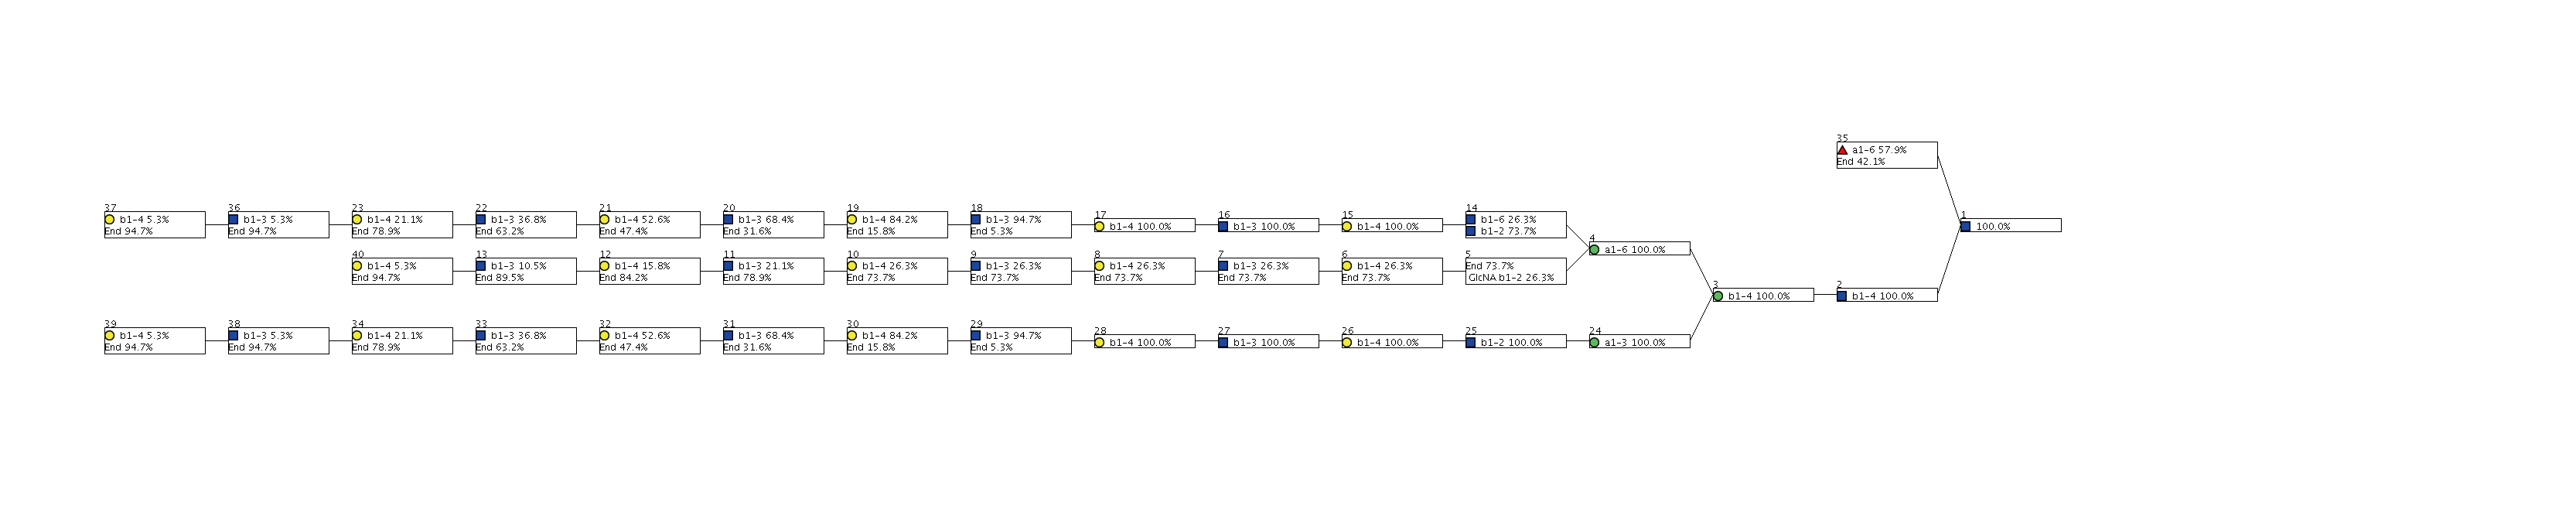

In [18]:
#help(Image)
Image(mcaw_img,width=3000) # double click on image to resize

In [19]:
        #return iupacstring

In [20]:


# Also send all the kcfs and return pics (just in case table above breaks)
def get_gly_image_html(kcfstring):
    try:
        kchandle2 = StringIO.StringIO(kcfstring)
        gct=pki.post_rings_kcf_to_image(kchandle2)
        return gct
    except Exception as e:
        return e
        #return iupacstring

kcfall = get_gly_image_html("".join(kcflist))

,
,
,
,
,
,
,
,
,
,
,

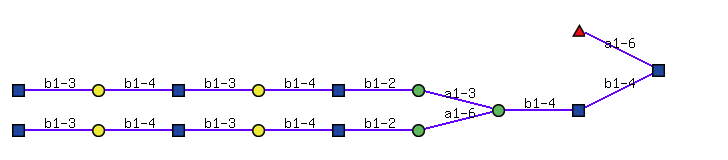
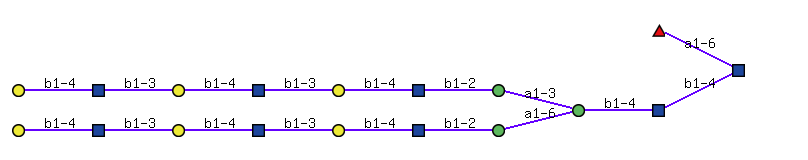
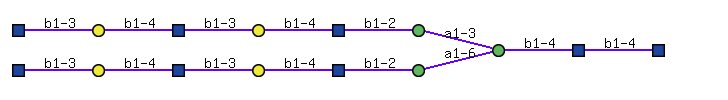
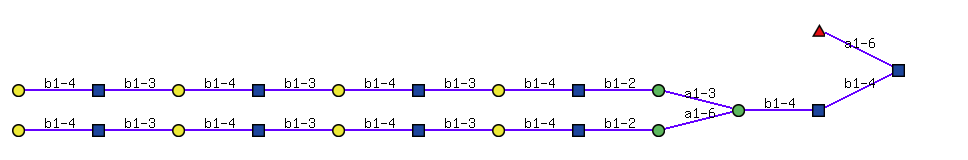
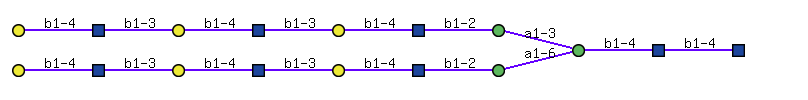
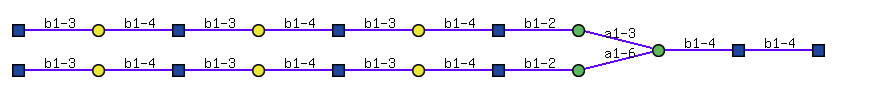
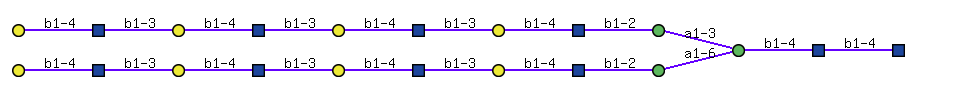
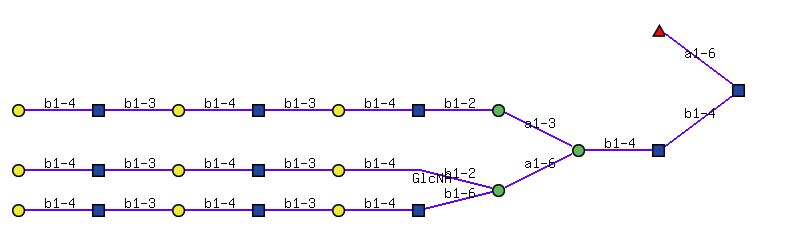
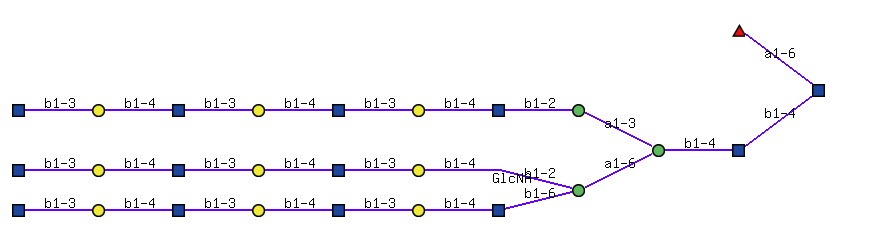
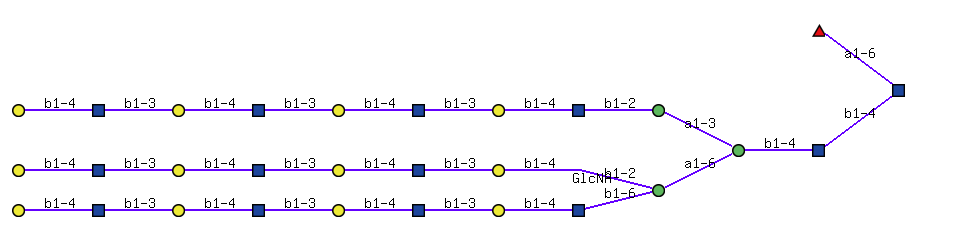
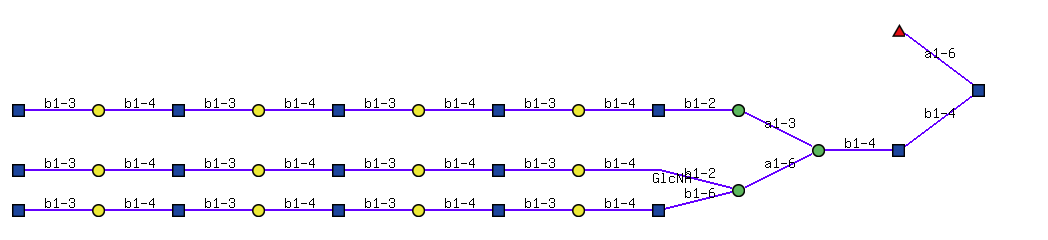
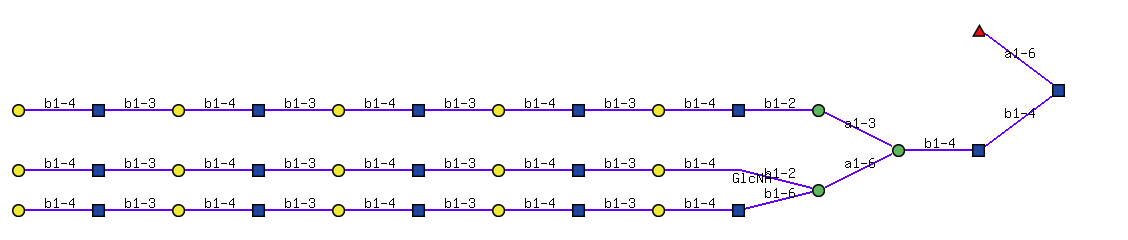
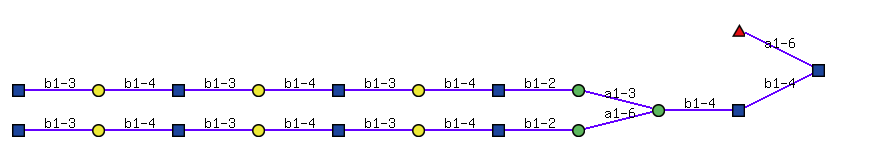
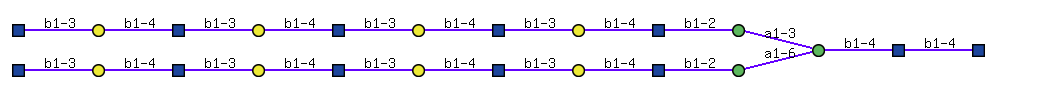
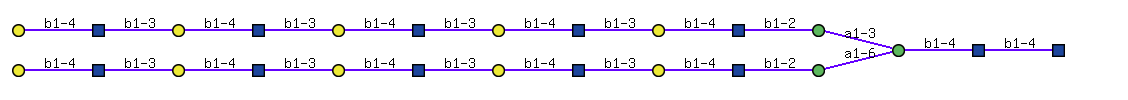
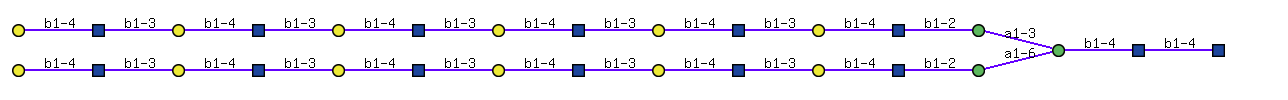
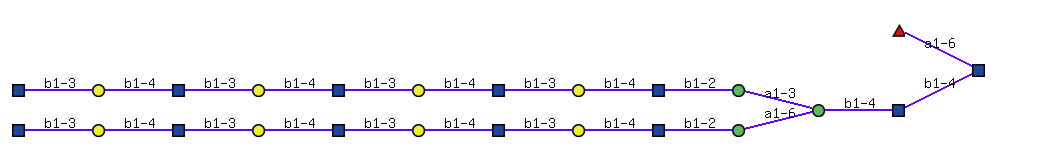
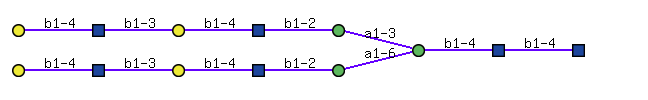
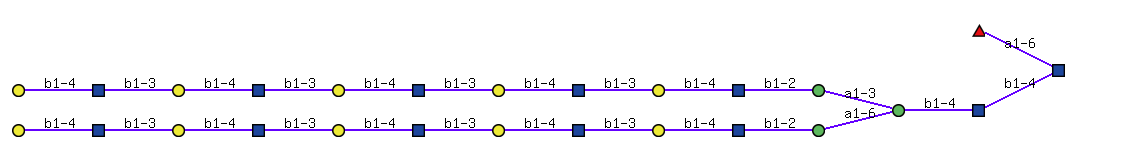

In [21]:
HTML(kcfall)